## AMNWt study
We study AMNWt model. We explicit and show the weights, give another way to compute the result of AMNWt. We also study the meaning of timestep parameter.

### Load the data, build and train the AMNWt model

In [2]:
import tensorflow as tf
from amn.model import AMNWtModel
from amn.model import LinearModel
import numpy as np

data_dir = "../data"
seed = 10

# np.random.seed(seed=seed)  
tf.random.set_seed(seed)

dataset_file = "/Dataset/iML1515_EXP_UB.npz"
objective = ["BIOMASS_Ec_iML1515_core_75p37M"]
epochs = 300
batch_size = 7 
uptake_max_index=None

model = AMNWtModel(dataset_file=data_dir + dataset_file, 
                   objective=objective,
                   timestep=4,
                   hidden_dim=500,
                   verbose=True,
                   uptake_max_index = uptake_max_index)
model.printout()

# Preprocessing
from amn.tools import MaxScaler
scaler= MaxScaler()
# model.train_test_split(test_size=0.1, random_state=seed)
model.train_test_split(test_size=0.1, random_state=seed)
model.preprocess(scaler)
model.preprocessing_for_specific_model()


AMNWt_model = model.build_model()
history = AMNWt_model.fit(model.X_train, model.Y_train, epochs=epochs, batch_size=batch_size, verbose=0)

print("R2 :", model.R2(model.Y_train, AMNWt_model.predict(model.X_train)))
print("Q2 :", model.R2(model.Y_test, AMNWt_model.predict(model.X_test)))

number of metabolites:  1080
filtered measurements size:  1
dataset file: ../data/Dataset/iML1515_EXP_UB.npz
model type: AMNWt
model medium bound: UB
timestep: 4
training set size (110, 38) (110, 1)
nbr hidden layer: 1
hidden layer size: 500
activation function: relu
R2 : 0.8338350604041228
Q2 : 0.7002150438770982


In [10]:
# influence of S on the model
null_row = []

for i in range(len(model.S)):
    null = True
    for j in range(model.S.shape[1]):
        if model.S[i][j].sum()!=0:
            null = False
    if null:
        null_row.append(i)

print("Number of lines in stoichiometry matrix :",model.S.shape[0]) 
print("Number of null lines in stoichiometry matrix :",len(null_row)) 
print("Number of non null lines in stoichiometry matrix :",model.S.shape[0] -len(null_row)) 
print("Rank of S :", np.linalg.matrix_rank(model.S))
print("Number of flux :",model.S.shape[1])
print("Dimension of the space SV=0 :", model.S.shape[1] - np.linalg.matrix_rank(model.S))

Number of lines in stoichiometry matrix : 1080
Number of null lines in stoichiometry matrix : 591
Number of non null lines in stoichiometry matrix : 489
Rank of S : 477
Number of flux : 543
Dimension of the space SV=0 : 66


Some lines of the stoichiometry matrix are null

In [11]:
null_row = []

for i in range(len(model.S)):
    null = True
    for j in range(model.S.shape[1]):
        if model.S[i][j].sum()!=0:
            null = False
    if null:
        null_row.append(i)

len(null_row) #591

591

In [12]:
AMNWt_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
repeat_vector_8 (RepeatVector)  (None, 6, 38)        0           input_9[0][0]                    
__________________________________________________________________________________________________
rnn_8 (RNN)                     (None, 543)          625021      repeat_vector_8[0][0]            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 581)          0           rnn_8[0][0]                      
                                                                 input_9[0][0]              

In [19]:
# Get weight of keras model
for layer in AMNWt_model.layers: 
    if "rnn" in layer.get_config()["name"]:
        # print(layer.get_config())
        W = layer.get_weights()

W_h, W_i, b_i, W_r, b_r = W


### Rewrite the AMNWt function as direct application

In [32]:
# AMNWt is just affine transformation, we explicit the matrix
C = np.matmul(W_h, W_i)
A = np.matmul(np.transpose(model.V2M), np.transpose(np.multiply(model.M2V_norm,W_r)))

def geometric_series_matrices(M,n):
    res = 0
    for i in range(n+1):
        res+=np.linalg.matrix_power(M,i)
    return res


# Those two functions equal to AMNWt
# Note that in AMNWt the initial vector in RNN object is set to zero by default !
def AMNWt_recursive_function(V_in,n):
    V_0 = np.matmul(np.matmul(V_in,C) +b_i, model.P_uptake)
    V = np.zeros((model.S.shape[1],))
    for i in range(n):
        M = np.matmul(V,tf.transpose(model.V2M))
        W = np.multiply(model.M2V_norm,W_r)
        V = np.matmul(M,tf.transpose(W))
        V = V + V_0 + b_r
    return V

def AMNWt_function(V_in,n):
    V_0 = np.matmul(np.matmul(V_in,C) +b_i, model.P_uptake)
    V = np.matmul((V_0+b_r),geometric_series_matrices(A,n-1))
    return V

M = np.matmul(np.matmul(C,model.P_uptake),
              geometric_series_matrices(A,3))
B = np.matmul(np.matmul(b_i, model.P_uptake)+b_r,
                  geometric_series_matrices(A,3))

def AMNWt_affine(V_in,n):
    return np.matmul(V_in,M) +B


print(AMNWt_recursive_function(model.X_test[0],4)[:5])
print(AMNWt_function(model.X_test[0],4)[:5])
print(AMNWt_affine(model.X_test[0],4)[:5])
print(AMNWt_model.predict(model.X_test)[0][:model.S.shape[1]][:5])

[ 0.46395171 -0.16887005  0.09137997  0.00086644 -0.08036842]
[ 0.46395171 -0.16887005  0.09137997  0.00086644 -0.08036842]
[ 0.46395171 -0.16887005  0.09137997  0.00086644 -0.08036842]
[ 0.46395123 -0.16886988  0.09137996  0.00086644 -0.08036841]


### Study the timestep parameter
The AMNWt function depend strongly on the adjacency matrix of the matrix between flux vertices. Every weight on $W_r$ is non null then the matrix A have the same non-nul weight than the adjacency matrix. The matrix $(Id + A + A² +A^3)$ propagate the flux along the flux graph. Since $n=3$ seems to be the best solution, isn't it some unseen fluxes, too far from the output flux. 

We can directly find unused elements by getting $0$ of the output column of the matrix $(Id + A + A² +A^3)$. Among them some come from the input.


In [33]:
# Index of reference flux
print("Reference flux indice :",[i for i in range(model.P_out.shape[1]) if model.P_out[:,i]==1])

# Research for useless input fluxes using directly A
# L = np.linalg.matrix_power(A,3)
L = geometric_series_matrices(A,3)
not_used_L = [i for i in range(len(L[:,424])) if L[i,424]==0]
print("Number of unused fluxes in AMNWt :",len(not_used_L))

# Indices of input fluxes 
model.P_in.shape
V_in = model.P_in.sum(axis=0)
input_indices = [i for i in range(len(V_in)) if V_in[i]!=0]
print("Number of unused fluxes input :",len(list(set(not_used_L) & set(input_indices))))

Reference flux indice : [424]
Number of unused fluxes in AMNWt : 51
Number of unused fluxes input : 19



Elements too far from the output must belong to these unused element. To compare lets compute fluxes with existing path of different length. Definitively, element with no path smaller than 4 should be in the unused set.

In [34]:
# All element of Adj matrix are positive
Adj = np.matmul(np.transpose(model.V2M), np.transpose(model.M2V))

# Compute adj to different power (gives matrices of existence of different length path)
max_power = 20
Adj_power = [np.linalg.matrix_power(Adj,i) for i in range(max_power+1)]

In [35]:
# Flux in a ball around ref
flux_with_path_to_ref = []
for length in range(max_power):
    flux_distance_length = []
    for i in range(Adj_power[length].shape[0]):
        if Adj_power[length][i,424]!=0:
            flux_distance_length.append(i)
    flux_with_path_to_ref.append(flux_distance_length)



length =[] 
reached_fluxes =[] 
input_reached_flux = []
for k in range(len(flux_with_path_to_ref)):
    length.append(k)
    reached_fluxes.append(len(flux_with_path_to_ref[k]))
    input_reached_flux.append(len([i for i in input_indices if i in flux_with_path_to_ref[k]]))

import pandas as pd
df = pd.DataFrame(data={"length" :length,
                        "reached_fluxes" :reached_fluxes, 
                        "reached_input" : input_reached_flux})
# df.to_csv("Flux_with_path_to_ref.csv")
df

,length,reached_fluxes,reached_input
0,0,1,0
1,1,204,0
2,2,401,0
3,3,487,19
4,4,503,25
5,5,510,31
6,6,510,31
7,7,510,31
8,8,510,31
9,9,510,31


In [36]:
flux_with_path_to_ref_max_length = [[]]

for k in range(len(flux_with_path_to_ref)):
    old = flux_with_path_to_ref_max_length[k]
    new = list(set(flux_with_path_to_ref_max_length[k] +flux_with_path_to_ref[k]))
    flux_with_path_to_ref_max_length.append(new)
               

flux_with_path_to_ref_max_length[1:]



length =[] 
reached_fluxes =[] 
input_reached_flux = []
for k in range(len(flux_with_path_to_ref_max_length[1:])):
    length.append(k)
    reached_fluxes.append(len(flux_with_path_to_ref_max_length[1:][k]))
    input_reached_flux.append(len([i for i in input_indices if i in flux_with_path_to_ref_max_length[1:][k]]))


# [print(f) for f in flux_near_ref]
# [print(f"Length from output : {l}, number of fluxes : {len(n)} {len([i for i in input_indices if i in n])}") for l,n in enumerate(flux_with_path_to_ref)]
# print("Max number of flux reached :", len(flux_distance_length))
# print("Min number not reach fluxes :", model.S.shape[1] - len(flux_distance_length))


import pandas as pd
df = pd.DataFrame(data={"length" :length,
                        "reached_fluxes" :reached_fluxes, 
                        "reached_input" : input_reached_flux})
# df.to_csv("Flux_with_path_to_ref.csv")
df

,length,reached_fluxes,reached_input
0,0,1,0
1,1,205,0
2,2,409,0
3,3,492,19
4,4,508,30
5,5,510,31
6,6,510,31
7,7,510,31
8,8,510,31
9,9,510,31


What are the intersection of p-connected flux for p =1,2,3 

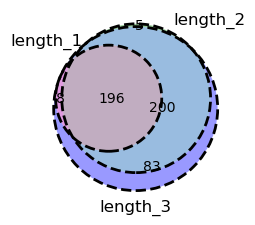

In [37]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib_venn import venn3_circles

s0 = set(flux_with_path_to_ref[0])
s1 = set(flux_with_path_to_ref[1])
s2 = set(flux_with_path_to_ref[2])
s3 = set(flux_with_path_to_ref[3])

venn3([s1,s2,s3],('length_1','length_2', 'length_3'))
venn3_circles([s1,s2,s3],linestyle='dashed')

plt.show()

In [ ]:
[x for x in s2 if x not in s3]

Visualization of W_r and V_0

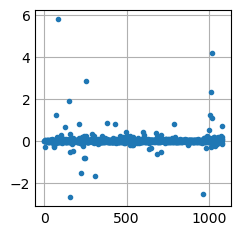

In [15]:
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

# Used in AMNWt
W_r_ = W_r[model.M2V_norm!=0]

plt.plot(W_r_,".")
plt.show()

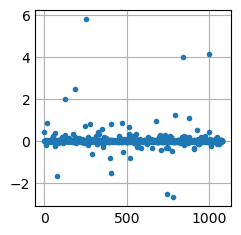

In [16]:
# W_r_ = np.multiply(W_r,model.M2V_norm!=0)
plt.plot(np.multiply(W_r,model.M2V_norm!=0).sum(axis=0),".")
plt.show()

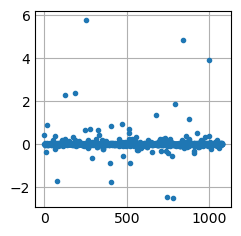

In [20]:
# W_r_ = np.multiply(W_r,model.M2V_norm!=0)
plt.plot(np.multiply(W_r,model.M2V_norm!=0).sum(axis=0),".")
plt.show()

<AxesSubplot:ylabel='Density'>

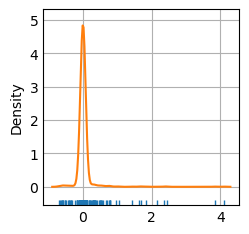

In [73]:
import seaborn as sns
sns.rugplot(W_r_)
sns.kdeplot(W_r_)

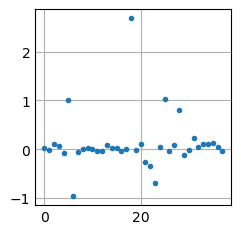

In [74]:
V_0_ = np.matmul(np.matmul(model.X_test[0],C) +b_i, model.P_uptake)

plt.plot(V_0_[input_indices], ".",)
plt.show()

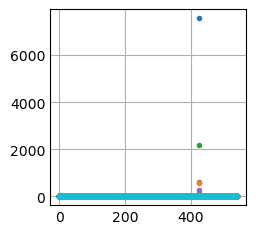

In [75]:

plt.plot(model.M2V_norm,".")
plt.show()

In [95]:
(model.M2V_norm >100).sum()

6

In [106]:
model.M2V[model.M2V >10000]

array([ 40000.        ,  18181.81818182,  38461.53846154, 500000.        ,
       142857.14285714,  10204.08163265])

In [131]:
# All hudge values are link to the biomass flux (424)
indices = []
for i in range(model.M2V.shape[0]):
    for j in range(model.M2V.shape[1]):
        if model.M2V[i,j] > 10000:
            indices.append((i,j))
            print(model.M2V[i,j])

indices

40000.0
18181.81818181818
38461.53846153846
500000.0
142857.14285714287
10204.081632653062


[(424, 467), (424, 664), (424, 811), (424, 830), (424, 872), (424, 1067)]

### Simple variant for AMNWt

Implementation without Keras RNN structure. Is it quicker ?

In [1]:
import tensorflow as tf
from amn.model import AMNWtModel
from amn.model import AMNWtModel_
from amn.model import LinearModel
import numpy as np

data_dir = "../data"
seed = 10
# np.random.seed(seed=seed)  
tf.random.set_seed(seed)

dataset_file = "/Dataset/iML1515_EXP_UB.npz"
objective = ["BIOMASS_Ec_iML1515_core_75p37M"]
epochs = 50 #100
batch_size = 7
uptake_max_index=None

model = AMNWtModel_(dataset_file=data_dir + dataset_file, 
                   objective=objective,
                   timestep=4,
                   hidden_dim=500,
                   verbose=True,
                   uptake_max_index = uptake_max_index)
model.printout()

# Preprocessing
from amn.tools import MaxScaler
scaler= MaxScaler()
model.train_test_split(test_size=0.1, random_state=seed)
model.preprocess(scaler)
model.preprocessing_for_specific_model()


AMNWt_model = model.build_model()
history = AMNWt_model.fit(model.X_train, model.Y_train, epochs=epochs, batch_size=batch_size, verbose=0)

print("R2 :", model.R2(model.Y_train, AMNWt_model.predict(model.X_train)))
print("Q2 :", model.R2(model.Y_test, AMNWt_model.predict(model.X_test)))

number of metabolites:  1080
filtered measurements size:  1
dataset file: ../data/Dataset/iML1515_EXP_UB.npz
model type: AMNWt
model medium bound: UB
timestep: 4
training set size (110, 38) (110, 1)
nbr hidden layer: 1
hidden layer size: 500
activation function: relu


2024-01-31 11:30:35.747897: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 11:30:35.749724: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-01-31 11:30:35.891647: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


R2 : 0.8159117119481836
Q2 : 0.7140630572945016


Linear weights

In [2]:
import tensorflow as tf
from amn.model import AMNWtModel
from amn.model import LinearModel

data_dir = "../data"
seed = 10
# np.random.seed(seed=seed)  
tf.random.set_seed(seed)

dataset_file = "/Dataset/iML1515_EXP_UB.npz"
objective = ["BIOMASS_Ec_iML1515_core_75p37M"]
epochs = 700
batch_size = 7
uptake_max_index=None

model = LinearModel(dataset_file=data_dir + dataset_file, 
                   objective=objective,
                   timestep=4,
                   hidden_dim=500,
                   verbose=True,
                   uptake_max_index = uptake_max_index)
model.printout()

# Preprocessing
from amn.tools import MaxScaler
scaler= MaxScaler()
model.train_test_split(test_size=0.1, random_state=seed)
model.preprocess(scaler)
model.preprocessing_for_specific_model()


AMNWt_model = model.build_model()
history = AMNWt_model.fit(model.X_train, model.Y_train, epochs=epochs, batch_size=batch_size, verbose=0)

print("R2 :", model.R2(model.Y_train, AMNWt_model.predict(model.X_train)))
print("Q2 :", model.R2(model.Y_test, AMNWt_model.predict(model.X_test)))

number of metabolites:  1080
filtered measurements size:  1
dataset file: ../data/Dataset/iML1515_EXP_UB.npz
model type: AMNWt
model medium bound: UB
timestep: 4
training set size (110, 38) (110, 1)
nbr hidden layer: 1
hidden layer size: 500
activation function: relu
R2 : 0.8351647063255723
Q2 : 0.6924364309962056
